# Data models

In [180]:
from typing import List
from typing import Callable
from typing import Tuple

class Rectangle:
    
    def __init__(self, width=0, height=0, x=0, y=0, ident=1):
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.ident = ident
        self.centerX = x+width/2
        self.centerY = y+height/2
    
    def __str__(self):
        return f'{self.ident}: ({self.width},{self.height},{self.x},{self.y}) whxy'
    
def decodeIntList(lst: List[str]) -> List[int]:
    return list(map(int, lst))

def decodeFloatList(lst: List[str]) -> List[float]:
    return list(map(float, lst))

def decodeRectangles(lst: List[str], idents: List[str]) -> List[Rectangle]:
    return list(map(decodeRectangle, *(lst,idents)))

def decodeRectangle(rec: str, ident: str) -> Rectangle:
    x,y,w,h = rec.split(',')
    return Rectangle(x=int(x), y=int(y), width=int(w), height=int(h), ident=ident)


class Individual:
    def __init__(self, iteration: int, objectiveValue: int, paintingSeq: List[int], paintingSeqDecoded: List[int], paintingSeqRandomKey: List[float], slicingOrderDecoded: List[int], slicingOrderRandomKey: List[float], orientations: List[str], orientationsCapped: List[str], orientationsResolved: List[str], paintingAllocatedSpace: List[Rectangle], paintingPlacement: List[Rectangle]):
        self.iteration = iteration
        self.objectiveValue = objectiveValue
        self.paintingSeq = paintingSeq
        self.paintingSeqDecoded = paintingSeqDecoded
        self.paintingSeqRandomKey = paintingSeqRandomKey
        self.slicingOrderDecoded = slicingOrderDecoded
        self.slicingOrderRandomKey = slicingOrderRandomKey
        self.orientations = orientations
        self.orientationsCapped = orientationsCapped
        self.orientationsResolved = orientationsResolved
        self.paintingAllocatedSpace = paintingAllocatedSpace
        self.paintingPlacement = paintingPlacement
        
    @staticmethod
    def create(json: dict) -> 'Individual':
        return Individual(
            iteration=int(json['iteration']),
            objectiveValue=float(json['objectiveValue']),
            paintingSeq=json['paintingSeq'],
            paintingSeqDecoded=json['paintingSeqDecoded'],
            paintingSeqRandomKey=decodeFloatList(json['paintingSeqRandomKey']),
            slicingOrderDecoded=decodeIntList(json['slicingOrderDecoded']),
            slicingOrderRandomKey=decodeFloatList(json['slicingOrderRandomKey']),
            orientations=json['orientations'],
            orientationsCapped=json['orientationsCapped'],
            orientationsResolved=json['orientations'], # TODO provide resolved orientations
            paintingAllocatedSpace=decodeRectangles(json['paintingAllocatedSpace_XYWH'], json['paintingSeqDecoded']),
            paintingPlacement=decodeRectangles(json['paintingPlacement_XYWH'], json['paintingSeqDecoded']))
    
class Painting:
    def __init__(self, ident: str, width: int, height: int):
        self.ident = ident
        self.width = width
        self.height = height
        
    @staticmethod
    def create(json: dict) -> 'Painting':
        return Painting(
            ident=json['ident'],
            width=int(json['width']),
            height=int(json['height']))
    
class HallOfFameRecord:
    def __init__(self, iteration: int, objectiveMin: float, objectiveMax: float, objectiveAvg: float, bestIndividual: Individual):
        self.iteration = iteration
        self.objectiveMin = objectiveMin
        self.objectiveMax = objectiveMax
        self.objectiveAvg = objectiveAvg
        self.bestIndividual = bestIndividual
    
    @staticmethod
    def create(json: dict) -> 'HallOfFameRecord':
        return HallOfFameRecord(
            iteration=int(json['iteration']),
            objectiveMin=float(json['objectiveMin']),
            objectiveMax=float(json['objectiveMax']),
            objectiveAvg=float(json['objectiveAvg']),
            bestIndividual=Individual.create(json['bestIndividual']))
            
class GaResult:
    def __init__(self, bestIndividual: Individual, hallOfFame: List[HallOfFameRecord]):
        self.bestIndividual = bestIndividual
        self.hallOfFame = hallOfFame
        
    @staticmethod
    def create(json: dict) -> 'GaResult':
        return GaResult(
            bestIndividual=Individual.create(json['bestIndividual']),
            hallOfFame=list(map(HallOfFameRecord.create, json['hallOfFame']['records'])))
    
class GaParameters:
    def __init__(self, maxNumberOfIter: int, populationSize: int, maximumWildCardCount: int, geneticAlgorithm: str, mate: str, mutate: str, select: str):
        self.maxNumberOfIter = maxNumberOfIter
        self.populationSize = populationSize
        self.maximumWildCardCount = maximumWildCardCount
        self.geneticAlgorithm = geneticAlgorithm
        self.mate = mate
        self.mutate = mutate
        self.select = select
        
    @staticmethod
    def create(json: dict) -> 'GaParameters':
        return GaParameters(
            maxNumberOfIter=int(json['maxNumberOfIter']),
            populationSize=int(json['populationSize']),
            maximumWildCardCount=int(json['maximumWildCardCount']),
            geneticAlgorithm=json['geneticAlgorithm'],
            mate=json['mate'],
            mutate=json['mutate'],
            select=json['select'])

class Layout:
    def __init__(self, width: int, height: int, evalFunc: str):
        self.width = width
        self.height = height
        self.evalFunc = evalFunc
        self.boundingRectangle = Rectangle(width=width, height=height, x=0, y=0, ident="")
        
    @staticmethod
    def create(json: dict) -> 'Layout':
        return Layout(width=json['width'], height=json['height'], evalFunc=json['evalFunc'])
    
class Flow:
    def __init__(self, src: int, dst: int, flow: float):
        self.src = src
        self.dst = dst
        self.flow = flow
        
    @staticmethod
    def create(json: dict) -> 'Flow':
        return Flow(
            src=int(json['from']),
            dst=int(json['to']),
            flow=float(json['flow']))
    
class InstanceParameters:
    def __init__(self, layout: Layout, paintings: List[Painting], paintingsFlow: List[Flow]):
        self.layout = layout
        self.paintings = paintings
        self.paintingsFlow = paintingsFlow
        
    @staticmethod
    def create(json: dict) -> 'InstanceParameters':
        return InstanceParameters(
            layout=Layout.create(json['layout']),
            paintings=list(map(Painting.create, json['paintings'])),
            paintingsFlow=list(map(Flow.create, json['paintingsFlow'])))
    
class ObjectiveParameters:
    def __init__(self, name: str, params: dict):
        self.name = name
        self.params = params
        
    @staticmethod
    def create(json: dict) -> 'ObjectiveParameters':
        return ObjectiveParameters(
            name=json['name'],
            params=json['params'])
        

class ComputationResult:
    def __init__(self, applicationVersion: str, createdAt: str, durationMillis: int, gaResult: GaResult, gaParameters: GaParameters, instanceParameters: InstanceParameters, objectiveParameters: ObjectiveParameters, name: str = None):
        self.applicationVersion = applicationVersion
        self.createdAt = createdAt
        self.durationMillis = durationMillis
        self.gaResult = gaResult
        self.gaParameters = gaParameters
        self.instanceParameters = instanceParameters
        self.objectiveParameters = objectiveParameters
        self.name = name
        
    @staticmethod
    def createWithName(name: str, json: dict):
        compRes = ComputationResult.create(json)
        compRes.name = name
        return compRes
    
    @staticmethod
    def create(json: dict) -> 'ComputationResult':
        return ComputationResult(
            applicationVersion=json['applicationVersion'],
            createdAt=json['createdAt'],
            durationMillis=int(json['durationMillis']),
            gaResult=GaResult.create(json['gaResult']),
            gaParameters=GaParameters.create(json['gaParameters']),
            instanceParameters=InstanceParameters.create(json['instanceParameters']),
            objectiveParameters=ObjectiveParameters.create(json['objectiveParameters']))
    
class Dataset:
    def __init__(self, name: str, instanceParameters: InstanceParameters):
        self.name = name
        self.instanceParameters = instanceParameters
        self.data = instanceParameters
        
    @staticmethod
    def create(json: dict) -> 'Dataset':
        return Dataset(
            name=json['name'],
            instanceParameters=InstanceParameters.create(json['data']))

# Utils

In [181]:
import os
import json

def findComputationResultFiles(directory):
    """Recursively searches a directory for files named 'computation_result.json'
    and returns a list of their paths using camel case."""

    resultFiles = []
    
    for item in os.listdir(directory):
        path = os.path.join(directory, item)
        
        if os.path.isdir(path):
            resultFiles += findComputationResultFiles(path)
        
        elif os.path.isfile(path) and item.lower() == 'computation_result.json':
            resultFiles.append(path)
    
    return resultFiles

def extractDatasetName(path):
    return path.split('/')[-2].rsplit('_',1)[0].split('_', 1)[1] # magic

def loadComputationResult(path: str, log=False) -> ComputationResult:
    if log:
        print(f'loading: {path}')
    with open(path, 'r') as f:
        data = json.load(f)
    
    return ComputationResult.createWithName(extractDatasetName(path), data)

def loadComputationResultsFromDirectoryRec(directory, sort=False):
    r = list(map(loadComputationResult, findComputationResultFiles(directory)))
    return r if not sort else sorted(r, key=lambda x: x.gaResult.bestIndividual.objectiveValue)

# Drawing

In [279]:
import matplotlib
import matplotlib.pyplot as plt

def hideSpinesAndTicks(ax):
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.axis('off')
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)    

def toMatplotlibRec(rec, **kwargs):
    return matplotlib.patches.Rectangle(
        (rec.x, rec.y),
        width=rec.width,
        height=rec.height,
        fill=False,
        **kwargs)

def drawRectangle(
    rec: Rectangle,
    ax,
    show_center=False, show_ident=False,
    **kwargs):
    ax.add_patch(toMatplotlibRec(rec, **kwargs))
    cx, cy = rec.x+rec.width/2, rec.y+(rec.height/2)
    
    if show_center:
        ax.scatter(rec.centerX, rec.centerY, color='black', s=1, alpha=1)
    if show_ident:
        k = 1.13 if show_center else 1
        ax.text(rec.centerX*k*0.95, rec.centerY*k*0.95, rec.ident, fontsize=8)
        
def drawRectangles(
    ax,
    recs: List[Rectangle],
    grid: Rectangle,
    show_ident=True, title=None, show_center=False):
    
    xmax, ymax = max(grid.width, max([r.x+r.width for r in recs])), max([r.y+r.height for r in recs])
    xmin, ymin = grid.width - xmax, grid.height - ymax
    xmin, xmax = -0.5, 30
    ymin, ymax = -0.5, 20
    
    s = 1.01
    ax.axis(xmin=xmin*s, xmax=xmax*s, ymin=ymin*s, ymax=ymax*s*1.05)
    print(grid.width, grid.height)
    
    drawRectangle(grid, ax, edgecolor='black', linewidth=1.4, alpha=0.5)
    for rec in recs:
        drawRectangle(rec, ax, edgecolor='black', show_center=show_center, linewidth=1.1,
                      show_ident=show_ident)

    if title:
        ax.set_title(f'{title}', fontsize=8)
    hideSpinesAndTicks(ax)
    
def drawComputationResult(res, name=None):
    fig, ax = plt.subplots(dpi=150)
    drawRectangles(
            ax=ax,
            recs=res.gaResult.bestIndividual.paintingPlacement,
            show_center=False,
            grid=res.instanceParameters.layout.boundingRectangle,
            title=None)
    if name:
        plt.savefig(f'figures/visualization_{name}.pdf', transparent=True, dpi=150);
    plt.show()

# Visualizations

## Bruteforce

24 19


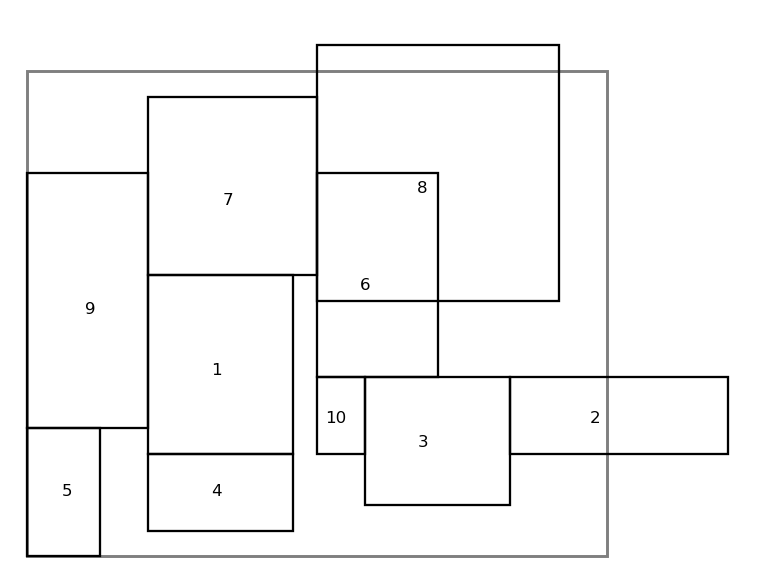

In [280]:
random10_brute = loadComputationResultsFromDirectoryRec('/home/slarty/Documents/master-thesis/src/notebooks/out/brute/012_random_10_95CF7', sort=True)
random20_brute = loadComputationResultsFromDirectoryRec('/home/slarty/Documents/master-thesis/src/notebooks/out/brute/013_random_20_82E19', sort=True)
drawComputationResult(random10_brute[0], 'random10_brute')
# drawComputationResult(random20_brute[0], 'random20_brute')

## GA

In [207]:
results = loadComputationResultsFromDirectoryRec('/home/slarty/Documents/master-thesis/src/notebooks/out/overlapping_penalization_constant_2023_04_12_01:26:44', sort=True)

24 19


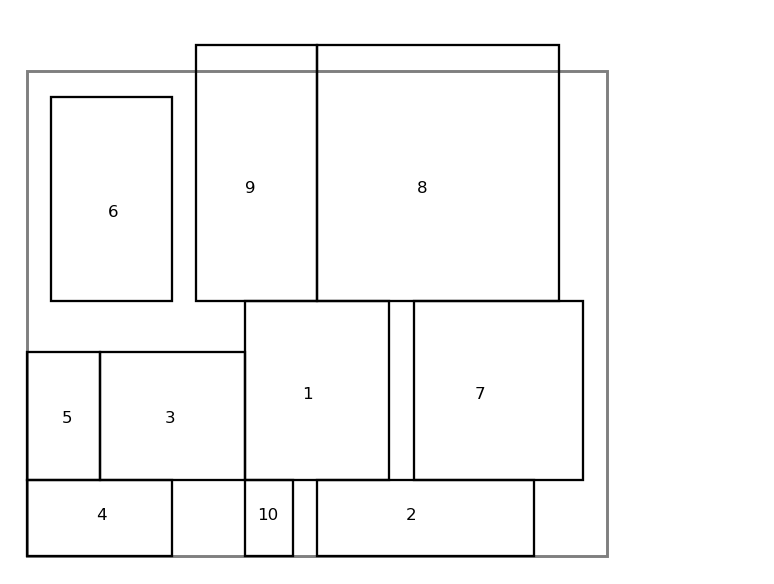

In [281]:
random10_ga = [x  for x in results if x.name == 'random_10']
packing10_ga = [x  for x in results if x.name == 'packing_10']
drawComputationResult(random10_ga[0], 'random10_ga')
# drawComputationResult(packing10_ga[0], 'packing10_ga')